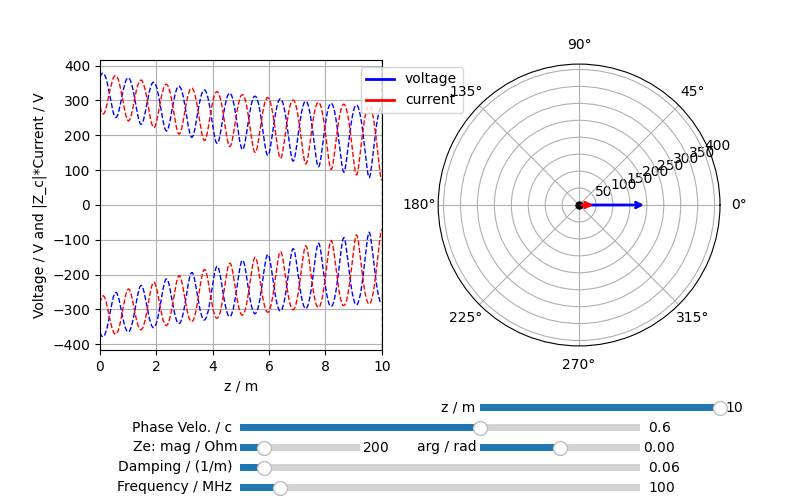

In [1]:
%matplotlib ipympl

import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.widgets import Slider,Button,RadioButtons
from IPython.display import HTML

# define parameters
frames = 40

class TL:
    def __init__(self, freq=100e6, 
                 vp_fac=0.6, 
                 a=0.06, 
                 Ie_mag=1, 
                 Ie_arg=0, 
                 Ze_mag=200, 
                 Ze_arg=0, 
                 Zc_mag=50, 
                 Zc_arg=0, 
                 zmin=0, zmax=10, zpoints=500):
        self.__c = 299792458 # speed of light
        self.update(freq=freq, 
                    vp_fac=vp_fac, 
                    a=a, 
                    Ie_mag=Ie_mag, 
                    Ie_arg=Ie_arg, 
                    Ze_mag=Ze_mag, 
                    Ze_arg=Ze_arg, 
                    Zc_mag=Zc_mag, 
                    Zc_arg=Zc_arg, 
                    zmin=zmin, 
                    zmax=zmax, zpoints=zpoints) 

    def update(self, freq=None, 
               vp_fac=None, 
               a=None, 
               Ie_mag=None, 
               Ie_arg=None, 
               Ze_mag=None,
               Ze_arg=None,
               Zc_mag=None, 
               Zc_arg=None, 
               zmin=None, 
               zmax=None, 
               zpoints=None):
        if freq is not None: 
            self.freq = freq
            self.w = 2 * np.pi * self.freq # angular frequency
            self.T = 1.0 / self.freq # period
            self.delta_t = self.T / frames
        if vp_fac is not None: 
            self.vp_fac = vp_fac
            self.v_p = self.__c * self.vp_fac
        if a is not None: self.a = a
        if Ie_mag is not None: self.Ie_mag = Ie_mag
        if Ie_arg is not None: self.Ie_arg = Ie_arg
        self.Ie = self.Ie_mag * np.exp(complex(0,1) * self.Ie_arg)
        if Ze_mag is not None: self.Ze_mag = Ze_mag
        if Ze_arg is not None: self.Ze_arg = Ze_arg
        self.Ze = self.Ze_mag * np.exp(complex(0,1) * self.Ze_arg)
        if Zc_mag is not None: self.Zc_mag = Zc_mag
        if Zc_arg is not None: self.Zc_arg = Zc_arg
        self.Zc = self.Zc_mag * np.exp(complex(0,1) * self.Zc_arg)
        self.r = (self.Ze - self.Zc) / (self.Ze + self.Zc)
        if zmin is not None: self.zmin=zmin
        if zmax is not None: self.zmax=zmax
        if zpoints is not None: self.zpoints=zpoints
        self.z = np.linspace(self.zmin, self.zmax, self.zpoints, endpoint=True)
        self.b = self.w / self.v_p # propagation constant
        self.l = self.v_p / self.freq # wavelength
        self.Uz = self.U()
        self.Iz = self.I()
        self.lower_u, self.upper_u = self.calc_enveloppe(self.u)
        self.lower_i, self.upper_i = self.calc_enveloppe(self.i)
        self.umin, self.umax = (1.1*np.min(self.lower_u), 1.1*np.max(self.upper_u))
            
    def U(self):
        g = complex(self.a,self.b)
        u1 = 0.5 * (self.Ze + self.Zc) * self.Ie * np.exp(g * (self.zmax - self.z))
        u2 = 0.5 * (self.Ze - self.Zc) * self.Ie * np.exp(-g * (self.zmax - self.z))
        return u1+u2

    def I(self):
        g = complex(self.a,self.b)
        i1 = 0.5 * (self.Ze + self.Zc) * self.Ie / self.Zc * np.exp(g * (self.zmax - self.z))
        i2 = -0.5 * (self.Ze - self.Zc) * self.Ie / self.Zc * np.exp(-g * (self.zmax - self.z))
        return i1+i2
    
    def u(self, t):
        return np.sqrt(2) * np.real(self.Uz * np.exp(complex(0,1)*self.w * t))

    def i(self, t):
        return np.sqrt(2) * np.real(self.Iz * np.exp(complex(0,1)*self.w * t))


    def calc_enveloppe(self, func):
        upper = np.zeros(self.zpoints)
        lower = np.zeros(self.zpoints)
        for t in self.T*np.linspace(0,1,frames,endpoint=True):
            ft = func(t)
            upper = np.maximum(upper, ft)
            lower = np.minimum(lower, ft)
        return lower, upper


tl=TL()
#print(tl.Uz)
#print(tl.Iz)

# create a figure and axes
plt.ioff()
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(1,2,1)
fig.subplots_adjust(bottom=0.3)

# set up the plot as needed
ax1.set_xlim((tl.zmin, tl.zmax))            
ax1.set_ylim((tl.umin, tl.umax))
ax1.set_xlabel('z / m')
ax1.set_ylabel('Voltage / V and |Z_c|*Current / V')
ax1.grid()

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
voltage, = ax1.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
current, = ax1.plot([], [], 'r', lw=2)
ul_voltage, = ax1.plot([], [], 'b--', lw=1)
ll_voltage, = ax1.plot([], [], 'b--', lw=1)
ul_current, = ax1.plot([], [], 'r--', lw=1)
ll_current, = ax1.plot([], [], 'r--', lw=1)
zline = ax1.axvline(tl.zmax, ls='--', color='g', lw=1, zorder=10)
# ax.legend(['fwd','bwd', 'sum']);
ax1.legend(['voltage','current'], bbox_to_anchor=(.9, 1.0), loc='upper left')


ul_voltage.set_data(tl.z, tl.upper_u)
ll_voltage.set_data(tl.z, tl.lower_u)
ul_current.set_data(tl.z, tl.upper_i * np.absolute(tl.Zc))
ll_current.set_data(tl.z, tl.lower_i * np.absolute(tl.Zc))


# animation function. This is called sequentially
def drawframe(n, instance):
    delta_t = instance.T/frames
    t = n * delta_t
    ax1.set_ylim((instance.umin, instance.umax))
    u = instance.u(t)
    i = instance.i(t)
    voltage.set_data(instance.z, u)
    current.set_data(instance.z, i * np.absolute(instance.Zc))
    txt_title.set_text(f"Time = {t/instance.T:.2f} T")
    return (voltage,current,)

plt.ion()

def sl_update(val, inst):
    inst.update(freq=1e6*freq_slider.val, 
                a=damp_slider.val, 
                vp_fac=vp_slider.val,
               Ze_mag=Zemag_slider.val,
               Ze_arg=Zearg_slider.val)
    #print(inst.Ze)
    umin, umax = inst.umin, inst.umax
    t = 0
    u = inst.u(t)
    i = inst.i(t)
    voltage.set_data(inst.z, u)
    current.set_data(inst.z, i)
    ul_voltage.set_data(tl.z, inst.upper_u)
    ll_voltage.set_data(tl.z, inst.lower_u)
    ul_current.set_data(tl.z, inst.upper_i * np.absolute(inst.Zc))
    ll_current.set_data(tl.z, inst.lower_i * np.absolute(inst.Zc))
    txt_title.set_text(f"Time = {t/inst.T:.2f} T")

    zindex = int(zind_slider.val/inst.zmax * inst.zpoints) - 1
    zindex = max(0, zindex)
    zindex = min(inst.zpoints, zindex)
    volt = inst.Uz[zindex]
    curr = inst.Iz[zindex]
    ax2.set_rmin(0)
    ax2.set_rmax(umax)
    atu.xy = (np.angle(volt), np.abs(volt))
    ati.xy = (np.angle(curr), np.abs(inst.Zc*curr))
    zline.set_xdata([zind_slider.val, zind_slider.val]) 
    
    fig.canvas.draw_idle()

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.3, 0.01, 0.5, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency / MHz',
    valmin=0,
    valmax=1000,
    valinit=1e-6*tl.freq
)

axdamp = fig.add_axes([0.3, 0.05, 0.5, 0.03])
damp_slider = Slider(
    ax=axdamp,
    label='Damping / (1/m)',
    valmin=0,
    valmax=1,
    valinit=tl.a
)

axZemag = fig.add_axes([0.3, 0.09, 0.15, 0.03])
Zemag_slider = Slider(
    ax=axZemag,
    label='Ze: mag / Ohm',
    valmin=0,
    valmax=1000,
    valinit=tl.Ze_mag
)

axZearg = fig.add_axes([0.6, 0.09, 0.2, 0.03])
Zearg_slider = Slider(
    ax=axZearg,
    label='arg / rad',
    valmin=-np.pi/2,
    valmax=np.pi/2,
    valinit=tl.Ze_arg
)

axvp = fig.add_axes([0.3, 0.13, 0.5, 0.03])
vp_slider = Slider(
    ax=axvp,
    label='Phase Velo. / c',
    valmin=0,
    valmax=1,
    valinit=tl.vp_fac
)

axzind = fig.add_axes([0.6, 0.17, 0.3, 0.03])
zind_slider = Slider(
    ax=axzind,
    label='z / m',
    valmin=0,
    valmax=tl.zmax,
    valinit=tl.zmax
)

# register the update function with each slider
freq_slider.on_changed(partial(sl_update, inst=tl))
damp_slider.on_changed(partial(sl_update, inst=tl))
vp_slider.on_changed(partial(sl_update, inst=tl))
Zemag_slider.on_changed(partial(sl_update, inst=tl))
Zearg_slider.on_changed(partial(sl_update, inst=tl))
zind_slider.on_changed(partial(sl_update, inst=tl))


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, partial(drawframe, instance=tl), frames=frames, interval=10, blit=True)

ax2 = fig.add_subplot(122, projection='polar')
ax2.plot(0, 0, color='black', marker='o', markersize=5)
zind = tl.zpoints-1
volt = tl.Uz[zind]
curr = tl.Iz[zind]
ax2.set_rmin(0)
ax2.set_rmax(tl.umax)
atu = ax2.annotate("", xy=(np.angle(volt), np.abs(volt)), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color="blue", lw=2))
ati = ax2.annotate("", xy=(np.angle(curr), np.abs(tl.Zc*curr)), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color="red", lw=2))

plt.show()